In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV

# Linear regression

In [ ]:




def train_linear_regression(
    data: pd.DataFrame, 
    target: str, 
    alphas: list[int] = [0.1, 1, 10, 100],
    num_transformer: str = 'robust',
    regularization: str = None,
    test_size: float = 0.2, 
    random_state: int = 42
):
    """
    Train a linear regression model with optional regularization.
    Calculates R² correctly for log-transformed targets.
    """
    # Separate features and target
    X = data.drop(target, axis=1)
    
    categorical_columns = X.select_dtypes(include=['object', 'category']).columns
    numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
    
    log_transformer = FunctionTransformer(np.log1p, validate=True)
    
    # Determine scaling and target transformation
    use_log_transform = num_transformer in ['log', 'log+robust']
    y = data[target]
    
    if num_transformer == 'robust': 
        num_pipeline = RobustScaler()
    elif num_transformer == 'standard': 
        num_pipeline = StandardScaler()
    elif num_transformer == 'log+robust':
        num_pipeline = Pipeline([
            ('log', log_transformer),
            ('scaler', RobustScaler())
        ])
        y = np.log1p(y)
    elif num_transformer == 'log+standard':
        num_pipeline = Pipeline([
            ('log', log_transformer),
            ('scaler', StandardScaler())
        ])
        y = np.log1p(y)
    elif num_transformer == 'log':
        num_pipeline = log_transformer
        y = np.log1p(y)
    else:
        num_pipeline = 'passthrough'

    # Create preprocessor with one-hot encoder for categories
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
            ('num', num_pipeline, numerical_columns)
        ])

    # Select appropriate regressor
    if regularization == 'ridge':
        regressor = Ridge()
        param_grid = {'regressor__alpha': alphas}
    elif regularization == 'lasso':
        regressor = Lasso(max_iter=50000, tol=0.001, selection='random') # for better stability reduced tolerance and large max_iter
        param_grid = {'regressor__alpha': alphas}
    else:
        regressor = LinearRegression()
        param_grid = {}

    # Create a pipeline with preprocessor and regression
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Fit the model
    if regularization in ['ridge', 'lasso']:
        grid_search = GridSearchCV(
            model, 
            param_grid, 
            cv=5, 
            scoring='neg_root_mean_squared_error'
        )
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        y_pred = best_model.predict(X_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        best_model = model
        best_params = {}

    # Correct R² calculation for log-transformed targets
    if use_log_transform:
        y_pred = np.expm1(y_pred)
        y_test = np.expm1(y_test)
        
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Due to one-hot encoding, we need to extract feature names from the preprocessor
    feature_names = (
        list(best_model.named_steps['preprocessor']
             .named_transformers_['cat']
             .get_feature_names_out(categorical_columns)) + 
        list(numerical_columns)
    )
    
    coefficients = pd.DataFrame({
        'feature': feature_names,
        'value': best_model.named_steps['regressor'].coef_,
        'importance': np.abs(best_model.named_steps['regressor'].coef_),
        'type': [ 'Numerical' if col in numerical_columns else 'Categorical' for col in feature_names]
    }).sort_values('importance', ascending=False)

    return {
        'model': best_model,
        'performance': {
            'root_mean_squared_error': rmse,
            'r2_score': r2
        },
        'best_params': best_params,
        'feature_importances': coefficients,
        'train_data': (X_train, y_train),
        'test_data': (X_test, y_test)
    }

In [24]:
# # print(results_lasso['feature_importances'])
# print("Number of features with zero coefficient in lasso regularization:",(results_lasso['feature_importances']['importance']==0.0).sum(), 'out of', (results_lasso['feature_importances']['importance']).count())
# print("Number of features with zero coefficient in lasso regularization:",(results_lasso['feature_importances']['importance']!=0).sum())
# print("Number of features with zero coefficient in ridge regularization:",(results_ridge['feature_importances']['importance']==0.0).sum())


For only cleaned data we necessarily need to apply log, so either log or log+robust

In [25]:

df = pd.read_csv('data/train_cleaned.csv')
trans_options = ['log', 'log+robust', 'log+standard']
regularization_options = [None, 'ridge', 'lasso']

best_r2 = float('-inf')
best_result = None

for trans in trans_options:
    for regularization in regularization_options:
        alphas = [1, 10, 100, 200] if regularization == 'ridge' else [0.0001, 0.001, 0.01, 0.1]
        results = train_linear_regression(df, target='SalePrice', alphas=alphas, num_transformer=trans, regularization=regularization)
        
        print(f'Results with preprocessing {trans} and regularization {regularization}:')
        for metric, value in results['performance'].items():
            print(f"{metric}: {value}")
        if regularization:
            print('The best alpha=', results['best_params']['regressor__alpha'])
        print("=" * 20)
        
        # Store the best model
        if results['performance']['r2_score'] > best_r2:
            best_r2 = results['performance']['r2_score']
            best_result = (trans, regularization, results)



Results with preprocessing log and regularization None:
root_mean_squared_error: 24585.016534232615
r2_score: 0.9211998262313611
Results with preprocessing log and regularization ridge:
root_mean_squared_error: 26611.495349261215
r2_score: 0.9076738504210954
The best alpha= 10
Results with preprocessing log and regularization lasso:
root_mean_squared_error: 27712.277893637292
r2_score: 0.899877746355222
The best alpha= 0.001
Results with preprocessing log+robust and regularization None:
root_mean_squared_error: 24920.74970868182
r2_score: 0.9190329395038187
Results with preprocessing log+robust and regularization ridge:
root_mean_squared_error: 25945.05395315101
r2_score: 0.9122402611767442
The best alpha= 10
Results with preprocessing log+robust and regularization lasso:
root_mean_squared_error: 27295.396991632722
r2_score: 0.9028674039661145
The best alpha= 0.001
Results with preprocessing log+standard and regularization None:
root_mean_squared_error: 0.14600666089916237
r2_score: 0.

In [26]:
# Print the best model at the end
if best_result:
    trans, regularization, results = best_result
    print("Best model:")
    print(f"Preprocessing: {trans}, Regularization: {regularization}")
    for metric, value in results['performance'].items():
        print(f"{metric}: {value}")
    if regularization:
        print('The best alpha=', results['best_params']['regressor__alpha'])
        
    print(results['feature_importances'].head(10))
        


Best model:
Preprocessing: log, Regularization: None
root_mean_squared_error: 24585.016534232615
r2_score: 0.9211998262313611
              feature     value  importance        dtype
394            YrSold -5.940510    5.940510    Numerical
365         YearBuilt  3.862770    3.862770    Numerical
366      YearRemodAdd  2.054811    2.054811    Numerical
334     PoolQC_NoPool  1.654377    1.654377  Categorical
89   RoofMatl_ClyTile -1.442921    1.442921  Categorical
332         PoolQC_Fa -0.675175    0.675175  Categorical
333         PoolQC_Gd -0.655239    0.655239  Categorical
66    Condition2_PosN -0.583138    0.583138  Categorical
316     GarageQual_Ex  0.524199    0.524199  Categorical
322     GarageCond_Ex -0.483230    0.483230  Categorical


### Linear regression conclusions:

From above we can see, that the best R2 is obtained for cleaned-only data using no regularization. Of course, given that we have almost 400 predictors (most from one-hot-encoding) and 1560 rows, there is no problem with overfitting to the data. Linear models tend to have relativily large bias due to strong assumptions, and regularization only enhances the bias without lowering variance. 

Somehow surprisingly the performance of the model with very good already, which indicates that linearity assumption approximately holds.

# Decision tree

In [3]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_squared_error, r2_score

def train_decision_tree_regression(
    data: pd.DataFrame, 
    target: str, 
    max_depth: list[int] = [2, 3, 5, 7, 10],
    min_samples_splits: list[int] = [2, 5, 10],
    min_samples_leaf: list[int] = [1, 2, 4],
    max_features: list[int, float, str] = [None, 'sqrt', 'log2'],
    num_transformer: str = 'robust',
    test_size: float = 0.2, 
    random_state: int = 42
):
    """
    Train a decision tree regression model with pruning and advanced preprocessing.
    Supports various numerical transformations and handles categorical features.
    
    Parameters:
    -----------
    data : pd.DataFrame
        Input dataset
    target : str
        Name of the target column
    pruning_depths : list
        Maximum depths to test for pruning
    min_samples_splits : list
        Minimum number of samples required to split an internal node
    num_transformer : str
        Numerical feature transformation method
        Options: 'robust', 'standard', 'log', 'log+robust', 'log+standard'
    test_size : float
        Proportion of the dataset to include in the test split
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    dict : A dictionary containing model, performance metrics, 
           best parameters, and feature importances
    """
    # Separate features and target
    X = data.drop(target, axis=1)
    
    # Identify column types
    categorical_columns = X.select_dtypes(include=['object', 'category']).columns
    numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
    
    # Log transformer for skewed features
    log_transformer = FunctionTransformer(np.log1p, validate=True)
    
    # Determine scaling and target transformation
    y = data[target]
    use_log_transform = num_transformer in ['log', 'log+robust', 'log+standard']
    
    # Create numerical preprocessing pipeline
    if num_transformer == 'robust': 
        num_pipeline = RobustScaler()
    elif num_transformer == 'standard': 
        num_pipeline = StandardScaler()
    elif num_transformer == 'log+robust':
        num_pipeline = Pipeline([
            ('log', log_transformer),
            ('scaler', RobustScaler())
        ])
        y = np.log1p(y)
    elif num_transformer == 'log+standard':
        num_pipeline = Pipeline([
            ('log', log_transformer),
            ('scaler', StandardScaler())
        ])
        y = np.log1p(y)
    elif num_transformer == 'log':
        num_pipeline = log_transformer
        y = np.log1p(y)
    else:
        num_pipeline = 'passthrough'

    # Create preprocessor with one-hot encoder for categories
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
            ('num', num_pipeline, numerical_columns)
        ])

    # Define parameter grid for grid search
    # param_grid = {
    #     'regressor__max_depth': max_depth,
    #     'regressor__min_samples_split': min_samples_splits
    # }
    param_grid = {
    'regressor__max_depth': max_depth,
    'regressor__min_samples_split': min_samples_splits,
    'regressor__min_samples_leaf': min_samples_leaf,
    'regressor__max_features': max_features
}

    # Create decision tree regression pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=random_state))
    ])

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=5, 
        scoring='neg_root_mean_squared_error'
    )
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)

    # Correct R² calculation for log-transformed targets
    if use_log_transform:
        # Inverse transform predictions and actual values
        y_pred_original = np.expm1(y_pred)
        y_test_original = np.expm1(y_test)
        
        # Calculate metrics on original scale
        mse = mean_squared_error(y_test_original, y_pred_original)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_original, y_pred_original)
    else:
        # Use original scale calculations
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

    # Get feature names
    feature_names = (
        list(best_model.named_steps['preprocessor']
             .named_transformers_['cat']
             .get_feature_names_out(categorical_columns)) + 
        list(numerical_columns)
    )
    
    # Extract feature importances
    importances = best_model.named_steps['regressor'].feature_importances_
    feature_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Return comprehensive results
    return {
        'model': best_model,
        'performance': {
            'root_mean_squared_error': rmse,
            'r2_score': r2
        },
        'best_params': best_params,
        'feature_importances': feature_importances,
        'train_data': (X_train, y_train),
        'test_data': (X_test, y_test)
    }

In [4]:
from sklearn.tree import plot_tree

Results with preprocessing robust:
root_mean_squared_error: 34750.092894909765
r2_score: 0.84256615382624
{'regressor__max_depth': 11, 'regressor__max_features': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 20}
Best model:
Preprocessing: robust
root_mean_squared_error: 34750.092894909765
r2_score: 0.84256615382624
{'regressor__max_depth': 11, 'regressor__max_features': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 20}


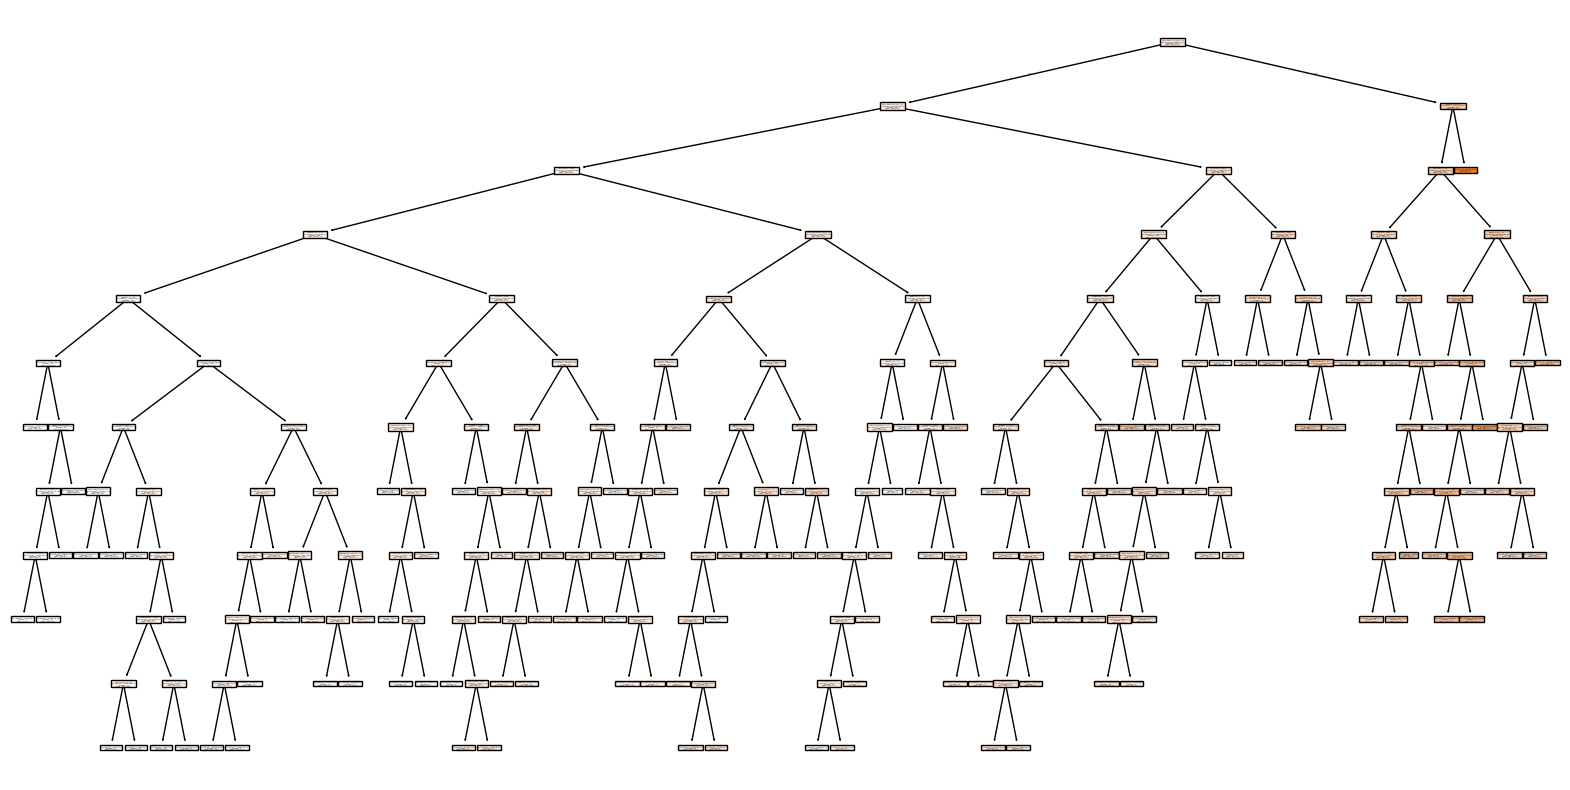

In [6]:
# df = pd.read_csv('data/train_cleaned.csv')
df = pd.read_csv('data/train_full_EDA.csv')
trans_options = ['robust'] # this is the best preprocessing
# trans_options = ['robust', 'standard', 'log', 'log+robust', 'log+standard']

best_r2 = float('-inf')
best_result = None

for trans in trans_options:
    results_tree = train_decision_tree_regression(
        df, target='SalePrice', min_samples_splits=[10, 20, 30], max_depth=[ 7, 9, 11, 13, 15, 20], num_transformer=trans
    )
    
    print(f'Results with preprocessing {trans}:')
    for metric, value in results_tree['performance'].items():
        print(f"{metric}: {value}")
    print(results_tree['best_params'])
    
    # Store the best model
    if results_tree['performance']['r2_score'] > best_r2:
        best_r2 = results_tree['performance']['r2_score']
        best_result = (trans, results_tree)

# Print the best model at the end and visualize it
if best_result:
    trans, results_tree = best_result
    best_model = results_tree['model'].named_steps['regressor']  # Extract regressor from pipeline
    preprocessor = results_tree['model'].named_steps['preprocessor']  # Extract preprocessor from pipeline
    
    # Get transformed feature names
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).drop('SalePrice', axis=1).columns
    feature_names = (
        list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)) +
        list(numerical_columns)
    )

    print("Best model:")
    print(f"Preprocessing: {trans}")
    for metric, value in results_tree['performance'].items():
        print(f"{metric}: {value}")
    print(results_tree['best_params'])

    # Visualizing the tree
    plt.figure(figsize=(20, 10))
    plot_tree(best_model, filled=True, feature_names=feature_names)
    plt.show()
